In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import requests
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (4, 4)
mpl.rcParams['axes.grid'] = False

In [5]:
def limit_tf_gpu_memory():
    """Limit memory growth in tensorflow 2.x, using set_memory_growth"""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices(
                    'GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus),
                      "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
limit_tf_gpu_memory()

1 Physical GPUs, 1 Logical GPUs


# Load the model and its utilties function

In [6]:
def image_from_url(url, image_size):
    r = requests.get(url, stream=True)
    if r.status_code != requests.codes.ok:
        print("Image", url, "not found")
        return None
    else:
        image = tf.image.decode_image(r.content)
        image = tf.image.resize(image, image_size)
        # tf cast to float when resizing -- undoing
        image = tf.cast(image, 'uint8')
        return image

In [7]:
def get_predictions(model, batch):
    batch = tf.constant(batch)
    batch = tf.cast(batch, tf.float32)
    batch = preprocess_input(batch, mode='tf')
    return model.predict(batch)

In [8]:
def get_best_prediction(predictions):
    values, indices = tf.math.top_k(predictions[0])
    return {"class_id": int(indices[0]), "confidence": float(values[0])}

In [149]:
def display_predictions(predictions, top=5):
    """ Display image and its related model prediction if supplied
    top (int): many top-guesses to return.
    """

    # convinient utilties to lookup top predictions and its human labels 
    decoded_preds = decode_predictions(predictions, top=top)[0]
    
    labels = []
    x_pos = []
    probabilities = []
    for idx, label in enumerate(decoded_preds):
        labels.append(label[1])
        probabilities.append(label[2] * 100)
        x_pos.append(idx)


    plt.figure()

    plt.bar(x_pos, probabilities, color='blue')
    plt.xticks(rotation=45)
    plt.xlabel("Labels")
    plt.ylabel("Confidence (%)")
    plt.title("Model predictions")
    plt.xticks(x_pos, labels)

In [10]:
IMAGE_SIZE = (224, 224)
target_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
target_model.trainable = False

# Test model prediction

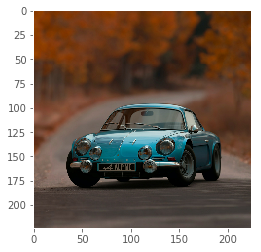

In [174]:
image_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
image_url = "https://images.pexels.com/photos/1592384/pexels-photo-1592384.jpeg?cs=srgb&dl=shallow-focus-photography-of-blue-alpine-car-1592384.jpg&fm=jpg"
image = image_from_url(image_url, IMAGE_SIZE)
plt.imshow(image)

In [175]:
predictions = get_predictions(target_model, image[None, ...])
best_prediction = get_best_prediction(predictions)
print(best_prediction)

{'class_id': 751, 'confidence': 0.8719369173049927}


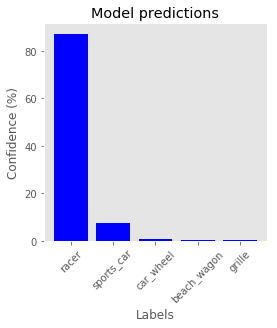

In [176]:
display_predictions(predictions)

# Define evolutionary model and its fitness function

In [177]:
from geneflow import GeneFlow
from geneflow.ops import Input, RandomMutations3D, UniformCrossover3D, DualCrossover3D, SingleCrossover3D
from geneflow.selection import SelectFittest
from geneflow.fitness import FitnessFunction
import geneflow.backend as B
import numpy as np

In [178]:
from geneflow.fitness import Sum

In [179]:
class AdversarialImage(FitnessFunction):

    def __init__(self, target_model, target_image, predict_function, best_prediction_function, expected_best_prediction, **kwargs):
        """Compute the sum of the gene as fitness value.

        Args:
            model (fn): Function used to get model predictions.
            best_prediction_function (fn): function that return the best prediction out of set.
            best_prediction (dict): What is the expected class and its confidence in the normal case.
            
        Note:
            we use a predict_function and best_prediction_function to make the adversarial fitness function agnostic
            to the model used.
        """
        super(AdversarialImage, self).__init__('adversarial_image', **kwargs)
        self.model = target_model
        self.target_image = B.tensor(target_image)
        self.predict = predict_function
        self.get_best = best_prediction_function
        self.expected = expected_best_prediction
        

    def call(self, population):
        # FIXME add batch size.
        # predicts our population results
        population = B.as_numpy_array(population)
        predictions = self.predict(target_model, population)        
        # first we check the confidence value of the targeted class
        scores = []
        for idx, prediction in enumerate(predictions):
            
            # find the best class and its confidence
            best_pred = self.get_best(prediction[None, ...])
            best_confidence =  best_pred['confidence']
            
            # the mutated image still predict the correct class - so the lower the better
            if best_pred['class_id'] == self.expected['class_id']:
                score = 1 - best_confidence

            # the mutated image predict an incorrect class -- now we want to minimize the changes
            else:

                mutated_image = B.tensor(population[idx])

                # FIXME: allows to use different diff function (mse, mae, huber, perceptual)
                diff = (B.sum(B.abs(self.target_image - mutated_image))) / 100000
                
                # score value is
                # 1/ diff minimize the difference
                # + best_score -> maximize the other class value
                # +1 ensure a mutated image is always better ranked than an image with the same class
                score = 1 /diff  + 1 + best_confidence  
            scores.append(float(score))
        return B.tensor(scores)
            

In [212]:
NUM_EVOLUTIONS = 1200
POPULATION_SIZE = 32

In [213]:
# create population

image_numpy = np.array(image)

population = []
for _ in range(POPULATION_SIZE): 
    population.append(image_numpy)

population = np.array(population)
print(population.shape)

(32, 224, 224, 3)


In [214]:
# basic evolution graph
inputs = Input(shape=population.shape)
x = RandomMutations3D(max_gene_value=255, min_gene_value=0)(inputs)
x = SingleCrossover3D(population_fraction=0.3)(x)
outputs = UniformCrossover3D(population_fraction=0.4)(x)


In [215]:
gf = GeneFlow(inputs, outputs, debug=False)
gf.summary()


OP (type)                                       Output Shape       Inputs
----------------------------------------------  -----------------  ------------------------
input_8B5844 (Input)                            (32, 224, 224, 3)
randommutations3d_A4761E (RandomMutations3D)    []                 input_8B5844
singlecrossover3d_062A85 (SingleCrossover3D)    []                 randommutations3d_A4761E
uniformcrossover3d_79AA05 (UniformCrossover3D)  []                 singlecrossover3d_062A85


In [216]:
evolution_strategy = SelectFittest()
fitness_fn = AdversarialImage(target_model, image_numpy, get_predictions, get_best_prediction, best_prediction)
gf.compile(evolution_strategy, fitness_fn)

In [217]:
results = gf.evolve(population, num_evolutions=NUM_EVOLUTIONS)

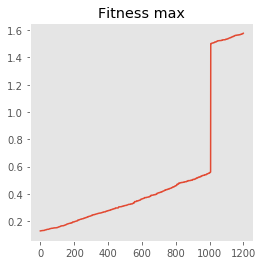

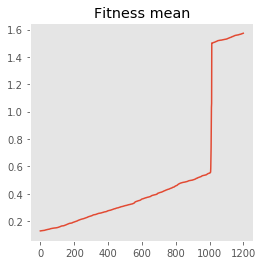

In [218]:
results.plot_metrics()

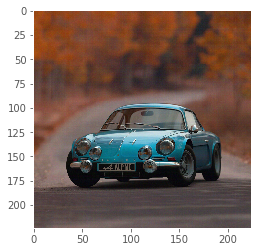

In [219]:
final_population = results.get_populations()
adversarial_img = B.as_numpy_array(final_population[0])
adversarial_img = adversarial_img.astype('uint8')
plt.imshow(adversarial_img)

In [220]:
adversarial_predictions = get_predictions(target_model, adversarial_img[None, ...])
adversarial_best_prediction = get_best_prediction(adversarial_predictions)
print(adversarial_best_prediction)

{'class_id': 817, 'confidence': 0.523379921913147}


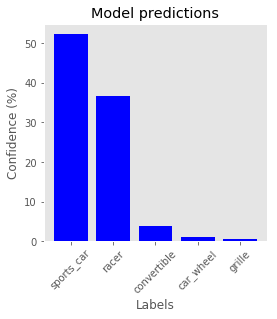

In [221]:
display_predictions(adversarial_predictions)

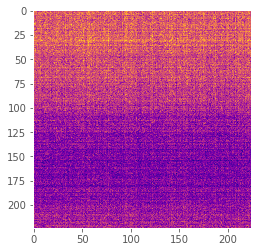

In [257]:
rgb_weights = [0.2989, 0.5870, 0.1140]

diff_map = -np.abs(image_numpy - adversarial_img)
diff_map = np.dot(diff_map[...,:3], rgb_weights)  # grey scale
diff_map /= diff_map.max()/255.0
plt.imshow(diff_map, cmap='plasma')